# Analysing drum patterns from MIDI files

In our first lesson we want to get to know how to work with datasets so we can

* parse a dataset
* analyse the dataset so it matches our expectations and we did not screw up during parsing

After this is done we want to take a look at how we can generate new drum patterns from the existing one.
But in order to do this we want to take a look at the quantisation (?) of our patterns.

The cleaning of the dataset and setting the data up properly takes the most time in such experiments but if one makes errors here those errors will propagate through our system - so its good to spend some time at this task.

In [17]:
import os
import glob

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from helpers.helpers import *

np.random.seed(42)  # makes the randomness deterministic

%matplotlib inline
# todo: try %matplotlib widget
plt.rcParams['figure.figsize'] = (15, 5)
plt.rcParams['axes.grid'] = True

## Getting the dataset

As our methods rely on data we need a way to obtain such data and this will be on of our first endeavours in this machine learning based workshop.
Thankfully there are search engines which help us to find data in the internet easily.
One search results when one searches for *midi dataset* is [https://colinraffel.com/projects/lmd/](https://colinraffel.com/projects/lmd/).

> The Lakh MIDI dataset is a collection of 176,581 unique MIDI files, 45,129 of which have been matched and aligned to entries in the Million Song Dataset. [...]

Of course the cultural skewness of such a dataset is a thing we need to be aware of.
What kind of music is transcribable into the MIDI format and what kind of music is transcribed as MIDI at all.
Maybe we can shed some light into the last question by inspecting the dataset.
But before we can do this we need to download and understand the dataset.

We use a function which will check if the files are already downloaded and if not will download and extract the directory.

In [ ]:
import urllib.request
import subprocess

def download_dataset(download_path: str = "../datasets/lmd"):
    os.makedirs(download_path, exist_ok=True)
    archive_dir = os.path.join(download_path, "lmd_full")
    
    dl_files = {
        "midi": {
            "path": os.path.join(download_path, "lmd_full.tap.gz"),
            "url": "http://hog.ee.columbia.edu/craffel/lmd/lmd_full.tar.gz"
        },
        "json": {
            "path": os.path.join(download_path, "md5_to_path.json"),
            "url": "http://hog.ee.columbia.edu/craffel/lmd/md5_to_paths.json"
        },
    }
    
    for dl_name, dl in dl_files.items():
        if os.path.isfile(dl["path"]) or (dl_name == "midi" and os.path.isdir(archive_dir)):
            print(f"{dl_name} already downloaded to {dl['path']}")
            continue
        print(f"Start downloading {dl_name} to {dl['path']} - this can take multiple minutes!")
        urllib.request.urlretrieve(dl['url'], dl['path'])
        print(f"Finished downloading")
    
    if not os.path.isdir(archive_dir):
        print("Start extracting the files of archive - this will take some minutes")
        # todo: windows has no tar
        subprocess.check_output([
            'tar', '-xzf', dl_files["midi"]["path"],
            '-C', os.path.join(download_path)
        ])
        print("Finished extracting")
    
    if os.path.isfile(dl_files["midi"]["path"]):
        print("Remove archive")
        os.remove(dl_files["midi"]["path"])

download_dataset()

Start downloading midi to ../datasets/lmd/lmd_full.tap.gz - this can take multiple minutes!


## Parsing the dataset

When working with large sets of files the unix utility [glob](https://en.wikipedia.org/wiki/Glob_(programming)) comes in handy as we can describe the pattern of the file paths we want to match instead of listing all files.

When we take a quick look at the pattern it seems they all follow a structure like

```
../datasets/lmd/lmd_full/2/4a0cbb3f083d14d57858c87b26f85873.mid
```

Soon we will understand why the filename has this cryptic format, but for now we simply want to parse all available files into an array.

In [3]:
midi_files = glob.glob('../datasets/lmd/lmd_full/*/*.mid')
print(f'Found {len(midi_files)} midi files in dataset')

Found 178561 midi files in dataset


In [4]:
# select 5 random files
np.random.choice(midi_files, 5)

array(['../datasets/lmd/lmd_full/4/4a69b1a10e4dbe409ac922de4f6256d8.mid',
       '../datasets/lmd/lmd_full/b/b102261b4c27ea58bad4777b5df5be5e.mid',
       '../datasets/lmd/lmd_full/3/3a8ccaab480919c35f37fdf08c238e29.mid',
       '../datasets/lmd/lmd_full/d/dc6416232e05b3d44fb62007ca84b474.mid',
       '../datasets/lmd/lmd_full/4/4fb744a04c1afbb0309b581410b33363.mid'],
      dtype='<U63')

But how are sure that we matched every midi file in our folder?
We can simply match every file in our dataset directory and show us the differences by using [sets](https://realpython.com/python-sets/).

In [5]:
missed_files = set(glob.glob('../datasets/lmd/lmd_full/**/*.*', recursive=True)) - set(midi_files)
print(f'Did not match {len(missed_files)} files')

Did not match 0 files


Thankfully we have a rather clean dataset here which does not force us to do file acrobatics.

But we did not just download MIDI files, we also downloaded a JSON file which we will now take a look into.

In [6]:
import json

with open("../datasets/lmd/md5_to_path.json") as f:
    md5_filenames = json.load(f)

md5_filenames["1c83fc02b8c57fbc2605900bb31793fb"]

['E/Exaltasamba - Megastar.mid',
 'Midis Samba e Pagode/Exaltasamba - Megastar.mid',
 'Midis Samba e Pagode/Exaltasamba - Megastar.mid']

So - why do we have an additional file which tells us the original filename?
This is actually a good trick in order to avoid duplicates in the dataset - we use a so called hash function which will return a cryptic string depending on the data that we *hash*.
Two files will produce the same hash output - so if we simple rename each file to the hash it produces we will automatically delete and detect all duplicates in our dataset.
This is a common practice if the data was obtained by scraping multiple sources for data.

Lets just take a look if we can verify this claim.

In [7]:
import hashlib

example_midi_file = "../datasets/lmd/lmd_full/1/1c83fc02b8c57fbc2605900bb31793fb.mid"

with open(example_midi_file, 'rb') as f:
    file_hash = hashlib.md5()
    while chunk := f.read(8192):
        file_hash.update(chunk)
print(f"Hash for {example_midi_file} is {file_hash.hexdigest()}")

Hash for ../datasets/lmd/lmd_full/1/1c83fc02b8c57fbc2605900bb31793fb.mid is 1c83fc02b8c57fbc2605900bb31793fb


This also gives us a nice additional information - a common MIDI file will probably have lots of different names as it was scraped from multiple files which probably changed the filenames a bit.

## Inspecting the data

Now as we have all file paths available it is a good practice to take a first look at the data.
We need to understand how the information we are interested in is accessible and also that it is probably not standardized - as we have seen above with the filenames already. 

To work with music notation we will use the python library [music21](https://web.mit.edu/music21/) from the MIT and [pretty_midi](https://github.com/craffel/pretty-midi) to inspect the MIDI files.

In [8]:
from music21 import converter

In [9]:
example_midi_file = np.random.choice(midi_files)
print(f'Selected {example_midi_file} as example MIDI file')
example_stream = converter.parse(example_midi_file)

Selected ../datasets/lmd/lmd_full/d/d3121806fccdc6bbdb727e1685c39bd0.mid as example MIDI file


In [10]:
print(stream_string(example_stream))

{0.0} <music21.stream.Part 0x153a30ca0>
    {0.0} <music21.instrument.Flute 'WinJammer Demo: Flute'>
    {0.0} <music21.tempo.MetronomeMark allegretto Quarter=106.0>
    {0.0} <music21.key.Key of C major>
    {0.0} <music21.meter.TimeSignature 4/4>
    {0.0} <music21.note.Rest rest>
    {52.0} <music21.note.Note F#>
    {53.0} <music21.note.Note E->
    {53.75} <music21.note.Note F#>
    {54.75} <music21.note.Rest rest>


As we can see a single score can take some time to process and analyse.
So before we process every file from our dataset we should take a look at a subset to watch out for any patterns.

Also it is worth making some research so we can reduce the amount of data we need to process.
From the [wikipedia article on General MIDI (GM)](https://en.wikipedia.org/wiki/General_MIDI#Percussive) we can see that percussive tracks should be on channel 10.

music21 has [a build in MIDI library](https://web.mit.edu/music21/doc/moduleReference/moduleMidi.html) but it is rather difficult and slow to extract the drums using music21 which is why we use *pretty_midi* for this task.

The [docs](https://web.mit.edu/music21/doc/moduleReference/moduleConverter.html) reveal that `music21.converter` seems to be the proper package.

We also start annotating our dataset using [pandas](https://pandas.pydata.org/) which is a library for data analysis and manipulation to keep track of any metadata the files have.
Especially the [apply](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.apply.html) method comes in handy here as we start with a list of MIDI file paths (see `load_midi_df`) and then we want to extend this list with some information from our MIDI file by applying the `parse_midi` function to all rows of our list.

Additionally we will use [caching](https://en.wikipedia.org/wiki/Cache_(computing)) because the meta-analyis of our MIDI files takes about 2 hours on my MacBook.
Caching means that we will store the results on the hard drive so once we calculated them we do not need to re-calculate them because we will just load the files from the hard drive.
It is a common practice in data science to write a function which either loads the data from a file or generates the file we are using as generating or calculating the data is a step which takes often a long time.

In [11]:
import pandas as pd
import pretty_midi as pm
from mido import KeySignatureError
import swifter

def parse_midi(row) -> bool:
    """
    Adds information about the MIDI file to a DataFrame row
    """
    try:
        sound = pm.PrettyMIDI(row['file_path'])
        row['midi_error'] = False
    # those are errors that were popping up when the whole dataset was parsed
    except (OSError, ValueError, IndexError, KeySignatureError, EOFError, ZeroDivisionError):
        row['midi_error'] = True
        return row
    
    try:
        row['beat_start'] = sound.estimate_beat_start()
        row['tempo'] = sound.estimate_tempo()
        row['end_time'] = sound.get_end_time()
        row['drums'] = any([i.is_drum for i in sound.instruments])
        row['resolution'] = sound.resolution
        # row['pitch_class_hist'] = sound.get_pitch_class_histogram()
        row['instrument_names'] = [i.name.strip() for i in sound.instruments]
        row['num_time_signature_changes'] = len(sound.time_signature_changes)
    except ValueError as e:
        # ValueError: Can't estimate beat start when there are no notes.
        # ValueError: Can't provide a global tempo estimate when there are fewer than two notes.
        print(f"Could not parse MIDI file {row['file_path']}: {e}")
    
    return row

def load_midi_df(
    save_path:str ='midi_df.parquet',
    dataset_path: str = '../datasets/lmd/lmd_full/',
    force_reload: bool = False
) -> pd.DataFrame:
    """
    Loads a dataframe with all available MIDI files in a folder
    and all 
    """
    if os.path.isfile(save_path) and not force_reload:
        print(f'Load dataframe from {save_path}')
        return pd.read_parquet(save_path)
    
    print(f'Load data to new dataframe')
    midi_files = glob.glob(os.path.join(dataset_path, '*/*.mid'))
    print(f'Found {len(midi_files)} midi files in folder {dataset_path}')
    
    midi_df: pd.DataFrame = pd.DataFrame({'file_path': midi_files})
    midi_df = midi_df.swifter.apply(parse_midi, axis=1)
    
    midi_df.to_parquet(save_path)
    print(f'Saved dataframe in {save_path}')
    
    return midi_df

In [12]:
midi_df = load_midi_df()
# select 15 random samples from our list
midi_df.sample(15)

Load dataframe from midi_df.parquet


beat_start  drums    end_time  \
81923     3.658535   True  128.780432   
171834    5.399796   True  467.992351   
161502    0.600000  False   38.283333   
39942     4.349159   True  254.776049   
100593    4.791044  False  190.137078   
44272     2.459015   True  228.161756   
15131     3.934424   True  251.814031   
34735    17.142852  False  340.282369   
45905     5.994792   True  280.114583   
12844     3.282020   True  193.497545   
114123    2.792100  False  100.750126   
14339     7.961539   True  330.377789   
131099    2.538459   True   51.692256   
124606    9.669701   True  273.626126   
136078    8.405307   True  217.860027   

                                                file_path  \
81923   ../datasets/lmd/lmd_full/f/f4b72836981feedb9e1...   
171834  ../datasets/lmd/lmd_full/5/53c9399ebac71119904...   
161502  ../datasets/lmd/lmd_full/2/212f54d7b9e586147c6...   
39942   ../datasets/lmd/lmd_full/6/609b19dde84d2374b7d...   
100593  ../datasets/lmd/lmd_full/d/de4dde0f1e960e41360...   
44272   ../datasets/lmd/lmd_full/6/6f74186f4c163863630...   
15131   ../datasets/lmd/lmd_full/0/0d8e9c4eb761a3e632b...   
34735   ../datasets/lmd/lmd_full/6/6d3149b41d088c63627...   
45905   ../datasets/lmd/lmd_full/1/1a931072e21340f256b...   
12844   ../datasets/lmd/lmd_full/0/0a7c38887ba4882921e...   
114123  ../datasets/lmd/lmd_full/4/455fcb4f4c5ad4d10da...   
14339   ../datasets/lmd/lmd_full/0/029c4baa3089eca3817...   
131099  ../datasets/lmd/lmd_full/3/353116ea8d2eb4041c9...   
124606  ../datasets/lmd/lmd_full/3/3574baf9f9cdfa4c3e1...   
136078  ../datasets/lmd/lmd_full/e/eb59c9f6854d897a03a...   

                                         instrument_names  midi_error  \
81923   [harmnica, accordn2, drum, acoubass, pianogrd,...       False   
171834  [Flutes, Flutes, Oboes, Oboes, Clarinets, Clar...       False   
161502                                         [Untitled]       False   
39942   [S-File, S-File, S-File, S-File, S-File, S-Fil...       False   
100593                                       [, , , , , ]       False   
44272   [drummix, bass, ac piano, Vocal, back voc, ac ...       False   
15131   [TAKE ME HOME                    Bextor/Aller/...       False   
34735   [Voice (Alto), Voice (Alto), Voice (Alto), Pia...       False   
45905   [A.PIANO 1, FINGERDBAS, A.PIANO 1, PAN FLUTE, ...       False   
12844   [CANDOMBE, PARA, GARDEL, http://fberni.tripod....       False   
114123                                                 []       False   
14339   [, Bass, Bass, Strings, Melodia, Slowstrings, ...       False   
131099               [MIDI Ch. 1, MIDI Ch. 2, MIDI Drums]       False   
124606  [Rhodes Piano, Synth Bass H, Synth Bass L, Aco...       False   
136078  [Bass / Acoustic bass, Piano / Rhodes, Melody ...       False   

        num_time_signature_changes  resolution       tempo  
81923                          1.0       384.0  175.232953  
171834                        19.0       192.0  188.547360  
161502                         1.0       480.0  194.117647  
39942                          1.0       384.0  237.529957  
100593                         0.0       192.0  170.384180  
44272                          1.0       480.0  242.119770  
15131                          1.0        96.0  245.724188  
34735                          6.0        96.0   84.000025  
45905                          1.0       384.0  207.446994  
12844                          1.0       480.0  224.582071  
114123                         1.0      1024.0  153.020774  
14339                          5.0       120.0  199.999987  
131099                         0.0        96.0  260.000260  
124606                         1.0       120.0  207.262310  
136078                         1.0       240.0  193.775528

Lets also attach the information about the possible file names.
A problem we observe here is that we have many possible file names for a single cryptic filename - this is called a *1:n* relationship and it is not best practice to put such a relation into one dataframe but for now we will do this.

In [13]:
def add_names_loop(df: pd.DataFrame):
    # we do not use apply as it consumes more memory and
    # takes a bit longer
    original_names, num_names = [], []
    for _, row in df.iterrows():
        md5_hash = row["file_path"].split("/")[-1].split(".")[0]
        names = md5_filenames[md5_hash]
        original_names.append(names)
        num_names.append(len(names))
    df["original_names"] = original_names
    df["num_names"] = num_names
    return df

add_names_loop(midi_df).head()

beat_start  drums    end_time  \
0    1.818180   True   22.599409   
1    1.904761  False   26.126684   
2    0.230769  False  188.999402   
3         NaN   None         NaN   
4    1.095833  False    6.475000   

                                           file_path        instrument_names  \
0  ../datasets/lmd/lmd_full/9/9fcfccf1c2245c74eb0...        [, , , , , , , ]   
1  ../datasets/lmd/lmd_full/9/9daedd9c5a390069a9c...  [reFX Nexus #2 (MIDI)]   
2  ../datasets/lmd/lmd_full/9/94078e08bc697e5ec56...                      []   
3  ../datasets/lmd/lmd_full/9/911cd08fa1fae36e5e0...                    None   
4  ../datasets/lmd/lmd_full/9/9d37fb70bc6886e3987...              [MIDI out]   

   midi_error  num_time_signature_changes  resolution       tempo  \
0       False                         1.0       384.0  239.659814   
1       False                         0.0        96.0  220.500143   
2       False                         2.0       256.0  253.787091   
3        True                         NaN         NaN         NaN   
4       False                         0.0        96.0  214.285714   

                                      original_names  num_names  
0  [Sure.Polyphone.Midi/Poly 1496.mid, Sure.Polyp...         11  
1  [W/Wildstylez_-_Pleasure_(Original_Mix)__kisga...          2  
2  [Classical_Guitar_classicalguitarmidi.com_MIDI...          1  
3                             [s/sou.mid, S/sou.mid]          2  
4                              [S/Sj - I Need U.mid]          1

Lets examine the extracted metadata of those files.

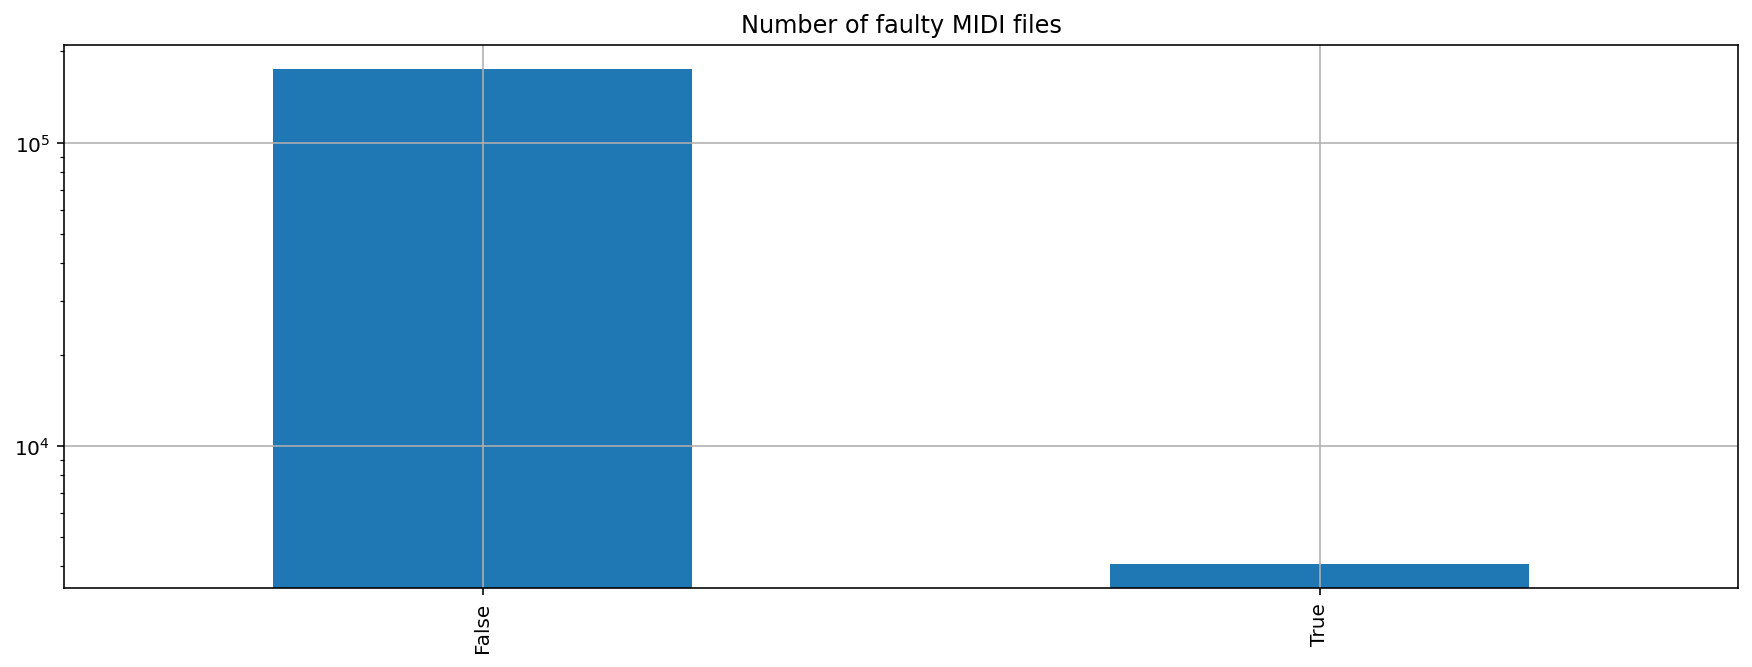

In [14]:
midi_df.midi_error.value_counts().plot.bar(logy=True)
plt.title("Number of faulty MIDI files");

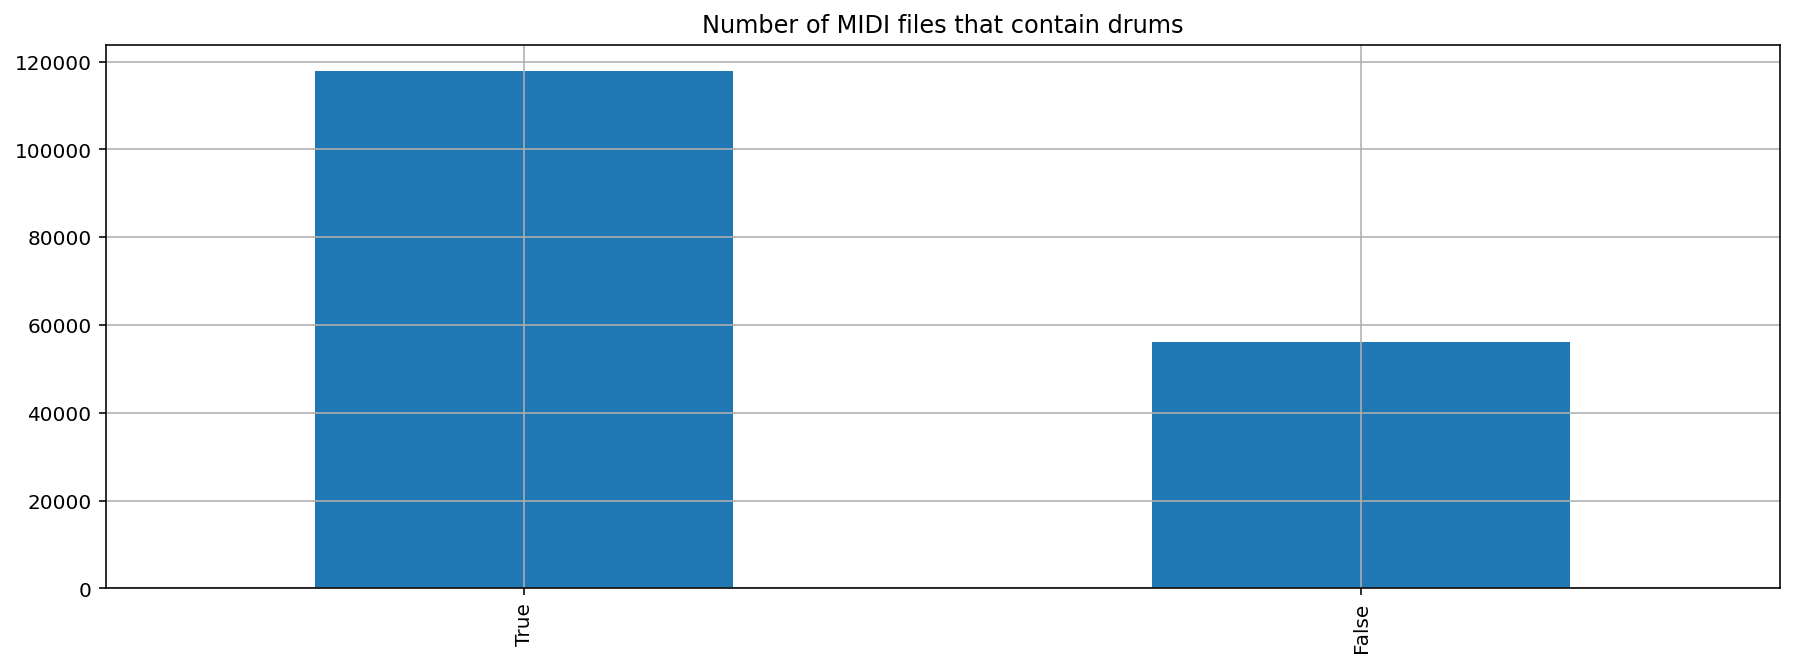

In [15]:
midi_df.drums.value_counts().plot.bar()
plt.title("Number of MIDI files that contain drums");

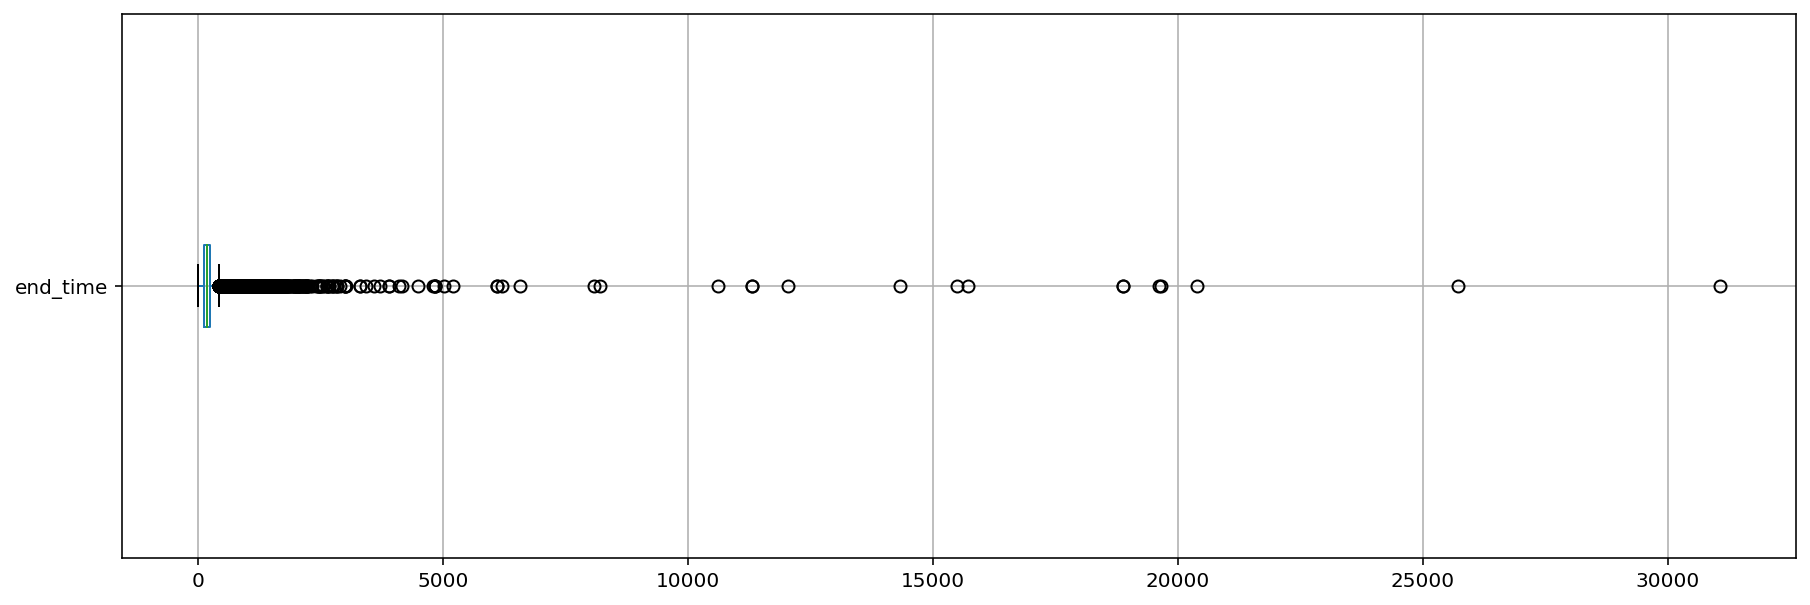

In [16]:
midi_df.end_time.plot.box(vert=False);

We see that the `end_time` has some extreme values that are probably wrong - lets inspect those examples closer to see if we can see a pattern.

In [17]:
midi_df.sort_values('end_time', ascending=False).head(10)

beat_start  drums      end_time  \
84737     0.468750  False  31055.625000   
28204     0.352941   True  25714.187790   
69901     1.263156   True  20384.791244   
26973     1.444671   True  19652.447880   
24515     1.016603   True  19623.803343   
47026    31.153327   True  18872.905893   
129390   31.153327   True  18872.905893   
52962     0.410958  False  15717.097325   
81576     0.677083   True  15491.909440   
65135     3.044301   True  14337.531639   

                                                file_path  \
84737   ../datasets/lmd/lmd_full/f/f7b41341a20201f860c...   
28204   ../datasets/lmd/lmd_full/7/7abab3566b77073f827...   
69901   ../datasets/lmd/lmd_full/a/af6b689cfbb13c302bd...   
26973   ../datasets/lmd/lmd_full/7/73f4f536d3d42293bd7...   
24515   ../datasets/lmd/lmd_full/7/7486b07d9a4060fa614...   
47026   ../datasets/lmd/lmd_full/1/15be4e0d9a337fbcc76...   
129390  ../datasets/lmd/lmd_full/3/3f981f6caf64d373e11...   
52962   ../datasets/lmd/lmd_full/1/1880f0001f6c5bd6c69...   
81576   ../datasets/lmd/lmd_full/f/fce329e7539459a23e4...   
65135   ../datasets/lmd/lmd_full/8/876255a805247c5fca2...   

                                         instrument_names  midi_error  \
84737   [Melody, On the Sun Road, Vivian Lai, Joseph L...       False   
28204                                    [, , , , , , , ]       False   
69901   [Acoustic Bass, Brass, Grand piano, Rock Organ...       False   
26973                    [tk1, tk2, tk3, tk4, tk10, tk11]       False   
24515   [Steel Str.Guitar, Fretless Bass, Piano, Violi...       False   
47026                      [, , , , , , , , , , , , , , ]       False   
129390                     [, , , , , , , , , , , , , , ]       False   
52962                                        [, , , , , ]       False   
81576   [A. Bass, Clas. Guit, A. Guitar, OPCIONAL, (Ma...       False   
65135                                    [, , , , , , , ]       False   

        num_time_signature_changes  resolution       tempo  \
84737                          2.0       120.0  225.041860   
28204                          9.0        96.0  220.109820   
69901                          7.0        96.0  229.041171   
26973                          1.0       192.0  144.311366   
24515                         13.0       192.0  181.059483   
47026                          1.0       120.0  216.170531   
129390                         1.0       120.0  216.170531   
52962                          1.0       192.0  263.729424   
81576                          3.0       384.0  179.936115   
65135                          1.0       120.0  190.305001   

                                           original_names  num_names  
84737                      [s/sunroad.mid, S/sunroad.mid]          2  
28204                                 [FErnszt/Olala.mid]          1  
69901                               [FErnszt/Swingin.mid]          1  
26973   [Clapton Eric/Bellbottom Blues.mid, Various Ar...         10  
24515                   [K/Kevin Parent Les Doigts 2.mid]          1  
47026                        [L/Les Lacs Du Conemara.mid]          1  
129390        [L/Les Lacs Du Connemara Michel Sardou.mid]          1  
52962            [Diversen Klassiek/DR_G.MID, D/DR_G.MID]          2  
81576                    [p/piensami.mid, P/piensami.mid]          2  
65135   [Diversen Kerst Muziek Traditional/O-Little-To...          5

Regarding this it seems we should filter out those really long pieces as those are most probably wrong files.

Those errors could be caused by our parsing or by the MIDI files itself - but as we have a big enough corpora it is justifiable by not including those outliers.

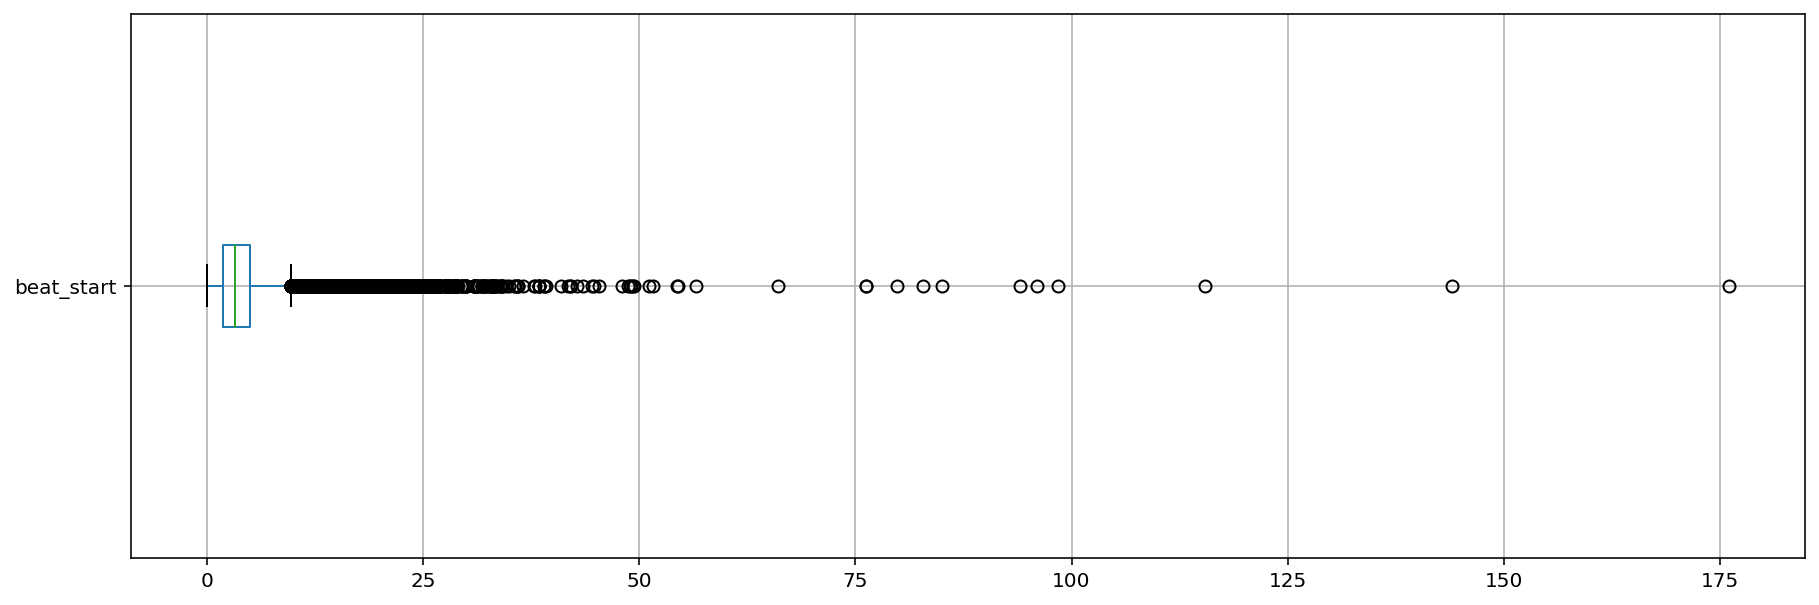

In [18]:
midi_df.beat_start.plot.box(vert=False);

`beat_start` looks ok, although we also should include some filtering here.

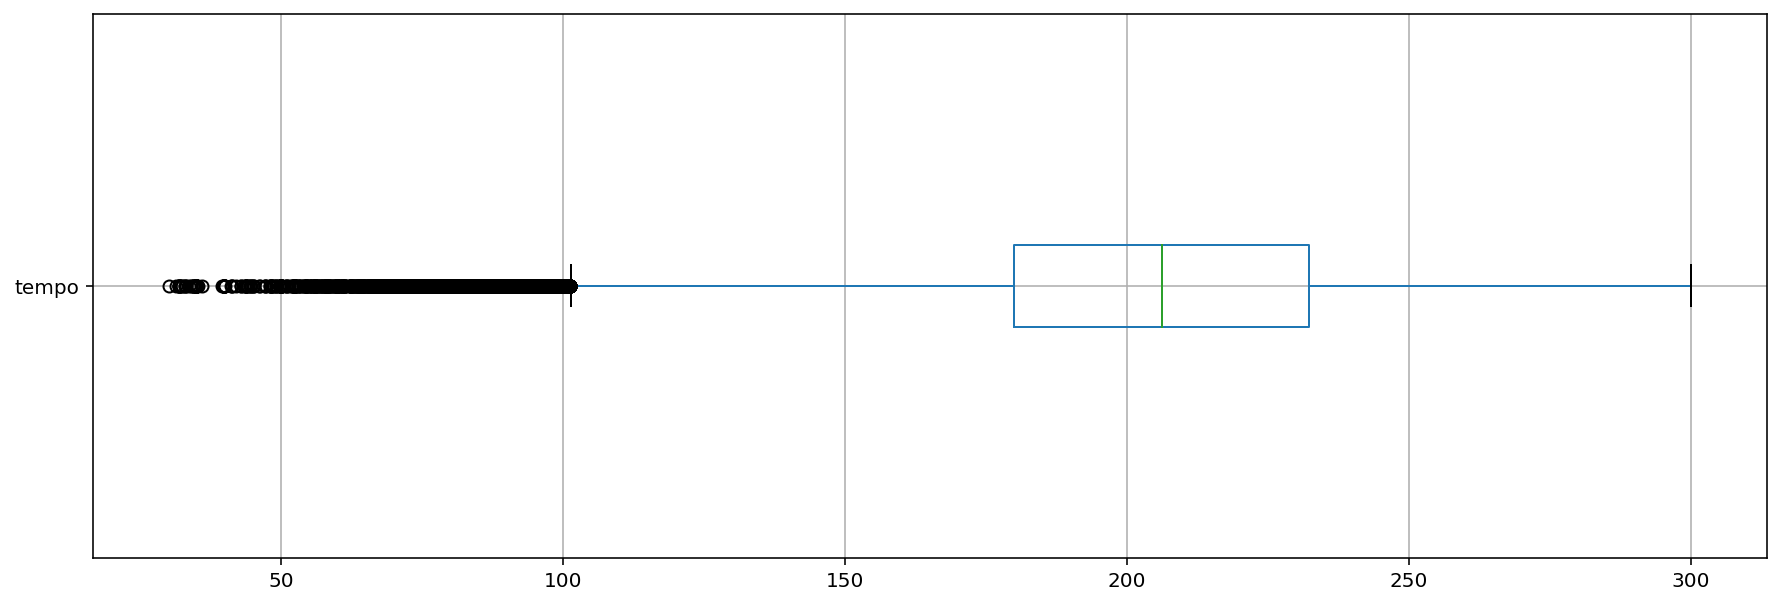

In [19]:
midi_df.tempo.plot.box(vert=False);

It is interesting to see that 95% of our examples are in the 200 bpm range - maybe they were transcribed in half time or we have a skewed dataset towards fast music which would be an interesting exploration what kind of music gets transcribed to MIDI files.

We need to inspect this further as drumming is closely related to the tempo of a song and we do not want to interpret the massive amount of data in a wrong way.

It is important to have an understanding and feeling for the data.
We have an expectation of our data which can help us to see if the data makes sense and if we parsed it correctly but can also always be problematic because we project certain expectations on an projection and simplification of our data.

**TODO** Flesh this out

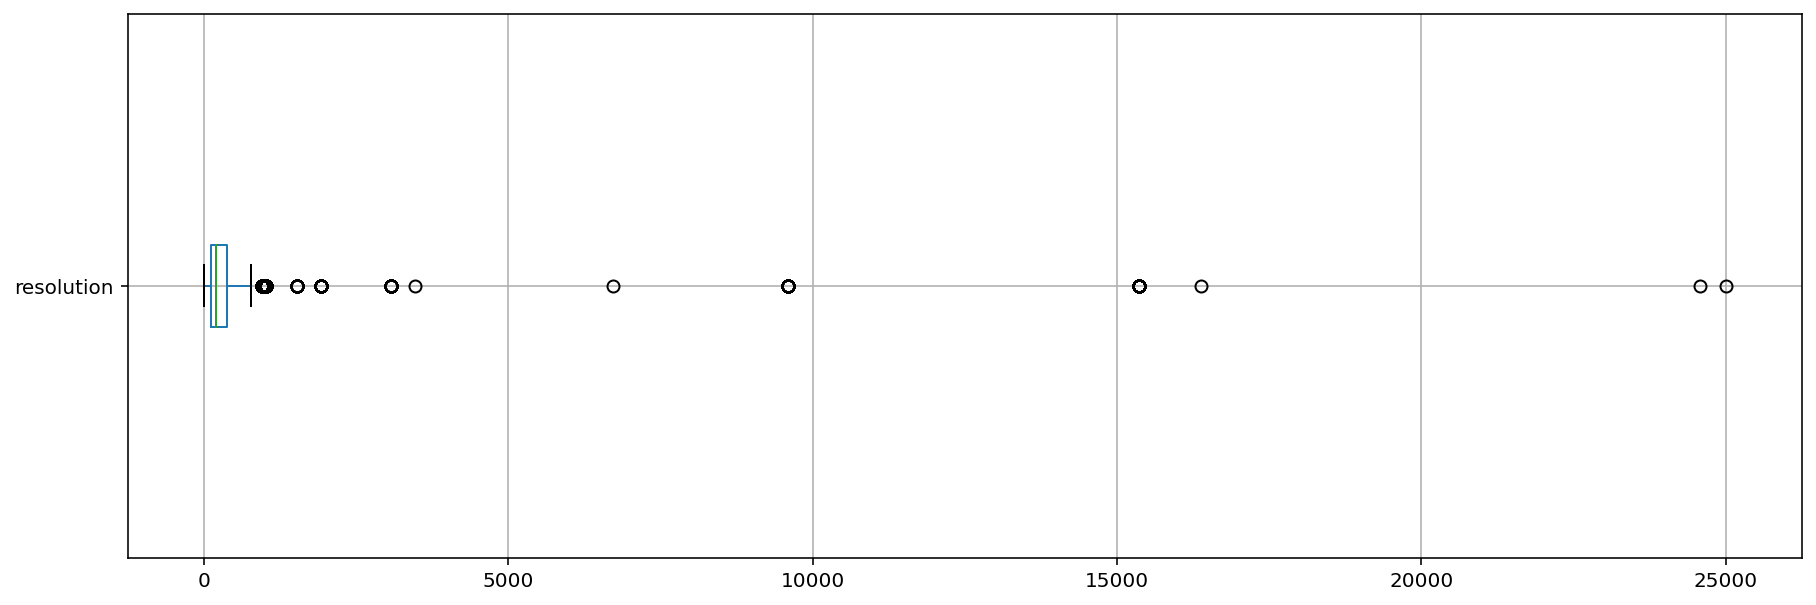

In [20]:
midi_df.resolution.plot.box(vert=False);

Resolution corresponds to the [PPQN](https://en.wikipedia.org/wiki/Pulses_per_quarter_note) of the MIDI file.
Everything above 1000 should be suspicious, so lets take a look at those examples.

In [21]:
midi_df.sort_values('resolution', ascending=False).head(10)

beat_start  drums    end_time  \
33871     2.000000  False  135.368840   
45187     1.071428   True   79.280092   
67351     0.250000  False   26.987488   
38884     0.642857  False   13.071416   
3838      1.499999  False   13.714272   
59166    14.014592  False   28.029184   
146384    0.671642  False    7.059232   
112102    1.521737  False    6.847817   
92169     1.655172  False   13.237066   
175242    1.499999  False   27.428544   

                                                file_path  \
33871   ../datasets/lmd/lmd_full/6/610987ebaf0a326db40...   
45187   ../datasets/lmd/lmd_full/1/1283eddbc4ab9042dcc...   
67351   ../datasets/lmd/lmd_full/a/a5c6eb45c94d84474cb...   
38884   ../datasets/lmd/lmd_full/6/63ecd58c3d030790cd9...   
3838    ../datasets/lmd/lmd_full/9/9f0df0be6a30b48a7a2...   
59166   ../datasets/lmd/lmd_full/8/80013e388373fca6ca3...   
146384  ../datasets/lmd/lmd_full/b/b95c22e47fb3dc8855a...   
112102  ../datasets/lmd/lmd_full/4/477fed40eecc0fd5051...   
92169   ../datasets/lmd/lmd_full/c/c3e63f5d16ed5a7124a...   
175242  ../datasets/lmd/lmd_full/5/5e35a0ca0be796095f8...   

                                         instrument_names  midi_error  \
33871                                            [, , , ]       False   
45187                                              [, , ]       False   
67351                                              [, , ]       False   
38884                                    [A Step Too Far]       False   
3838                                       [SubTractor 1]       False   
59166                                           [Strings]       False   
146384                                 [MELODY, BASSLINE]       False   
112102  [Matel disco music maker, Bass, Stylophone 1, ...       False   
92169                           [2 Best Enemies - Phases]       False   
175242                    [NN-XT 1, NN19 1, SubTractor 1]       False   

        num_time_signature_changes  resolution       tempo  \
33871                          1.0     25000.0  239.221606   
45187                          1.0     24576.0  225.608072   
67351                          2.0     16384.0  235.213491   
38884                          1.0     15360.0  227.500228   
3838                           1.0     15360.0  246.400246   
59166                          1.0     15360.0   51.375024   
146384                         1.0     15360.0  268.000116   
112102                         1.0     15360.0  276.000386   
92169                          1.0     15360.0  213.126196   
175242                         1.0     15360.0  280.000280   

                                           original_names  num_names  
33871   [b/beethovenalladanza.mid, B/beethovenalladanz...          2  
45187   [Pop_and_Top40/2 Pac - Changes.mid, Pop_and_To...          2  
67351                        [a/amigo3.mid, A/amigo3.mid]          2  
38884   [R/Refresh_-_A_Step_Too_Far__DJ_Exprice_200809...          2  
3838    [S/Svenrg Vs Bass T - The Sign (Pulsedriver Vs...          2  
59166   [F/ferry_corsten__everything_goes__tmf_awards_...          2  
146384  [D/Decoy_And_Roy_-_Innerlife__DJRenco_Sam_Cera...          1  
112102  [K/Kraftwerk_-_Dentaku__RueArsins_201302032206...          2  
92169   [2/2_Best_Enemies_-_Phases_(TBY_Romantic_Mix)_...          2  
175242           [D/Dusterix - Dusted (CJ Stone Mix).mid]          1

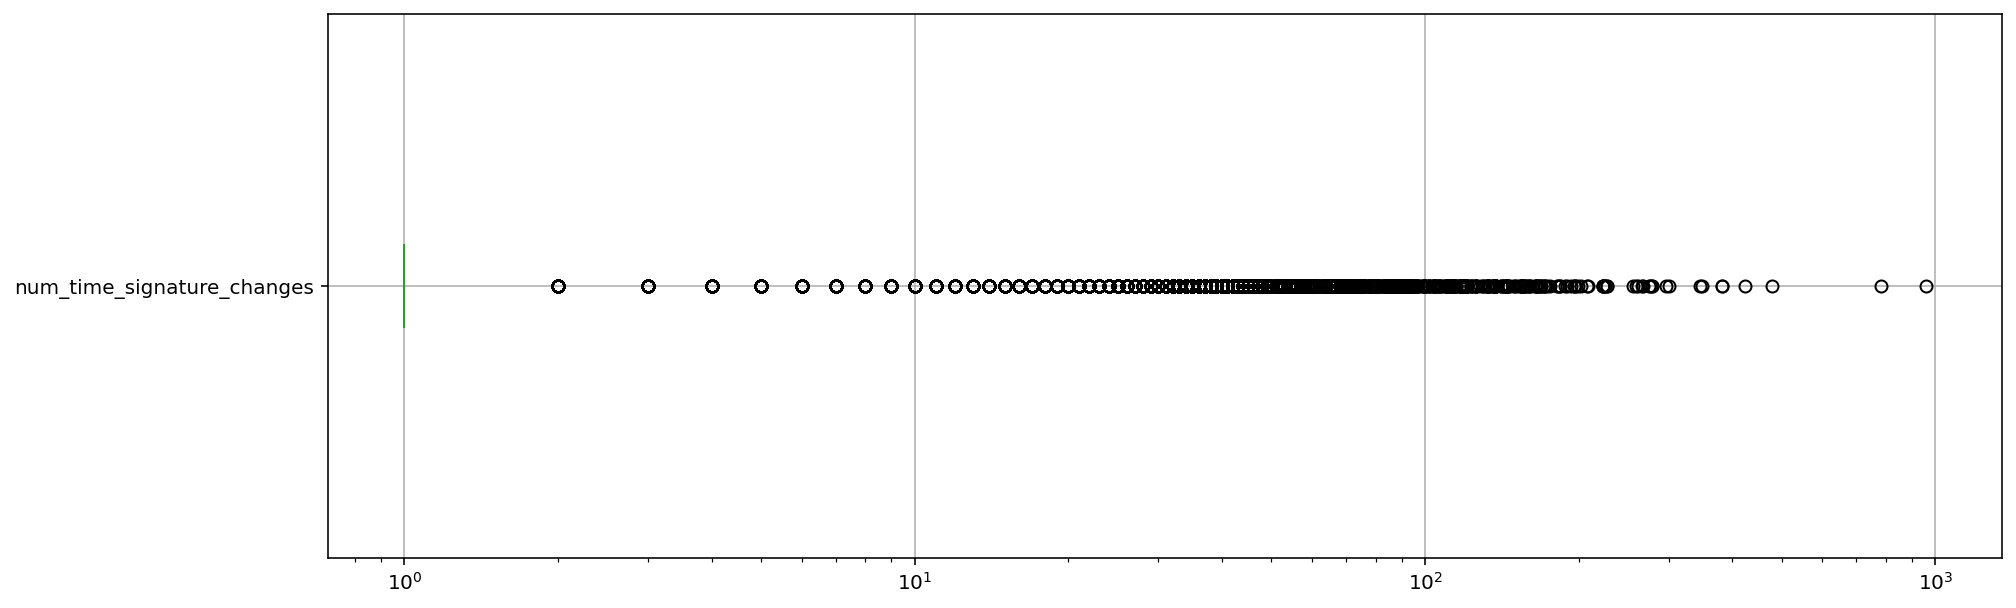

In [22]:
midi_df['num_time_signature_changes'].plot.box(vert=False, logx=True);

In [23]:
midi_df.sort_values('num_time_signature_changes', ascending=False).head(20)

beat_start  drums     end_time  \
72284     5.862357   True   204.310165   
26776     6.629205   True   229.441685   
168045    3.304224   True   255.266272   
60293     5.500000  False   283.476487   
44034     1.550000  False   407.079384   
93896     4.500000  False   785.261142   
89587     5.500000   True  2630.747499   
121888    1.909089  False  1340.480446   
163342    3.333332   True   336.817954   
26387     8.155336  False   621.914434   
172851    2.384100  False   311.196005   
93577     1.764705  False   197.860502   
37475     1.421050  False   261.473292   
7226      3.692304  False   507.230262   
16617     2.107142  False   232.490176   
157624    2.307690  False   243.575424   
101824    1.714284   True   651.247812   
116874    0.902254  False   235.054588   
14333     0.757575  False   285.805082   
13465     1.571427  False   105.217389   

                                                file_path  \
72284   ../datasets/lmd/lmd_full/a/a85612fb0992100bded...   
26776   ../datasets/lmd/lmd_full/7/7d42a95293cc47bcacf...   
168045  ../datasets/lmd/lmd_full/5/5693291bc82548fea37...   
60293   ../datasets/lmd/lmd_full/8/85b2d4e8637008f6b4e...   
44034   ../datasets/lmd/lmd_full/6/69df67cd25dd33c1217...   
93896   ../datasets/lmd/lmd_full/c/cf1767440a9e43e7193...   
89587   ../datasets/lmd/lmd_full/c/c0caac5c8affb877d36...   
121888  ../datasets/lmd/lmd_full/4/441c229736ca265a78b...   
163342  ../datasets/lmd/lmd_full/2/2021875aa51e2374eb5...   
26387   ../datasets/lmd/lmd_full/7/79cc201f43cb9fba7e6...   
172851  ../datasets/lmd/lmd_full/5/526e17017303fc5bbc1...   
93577   ../datasets/lmd/lmd_full/c/c883d35b66bbe8e9fb9...   
37475   ../datasets/lmd/lmd_full/6/6c605d6883a3968e79d...   
7226    ../datasets/lmd/lmd_full/9/9b8851148b17284c11e...   
16617   ../datasets/lmd/lmd_full/0/0c98c404a173d2ae168...   
157624  ../datasets/lmd/lmd_full/2/2f5ba581b764e82e991...   
101824  ../datasets/lmd/lmd_full/d/d93e70ee04dec17d544...   
116874  ../datasets/lmd/lmd_full/4/412b3106915479daf12...   
14333   ../datasets/lmd/lmd_full/0/01e682c8e1a7dd5b0b7...   
13465   ../datasets/lmd/lmd_full/0/02a4ab472b9071825a3...   

                                         instrument_names  midi_error  \
72284   [STRAUSS, STRAUSS, STRAUSS, STRAUSS, STRAUSS, ...       False   
26776   [NACHT, NACHT, NACHT, NACHT, NACHT, NACHT, NACHT]       False   
168045  [VIBRA SLAP, VIBRA SLAP, VIBRA SLAP, VIBRA SLA...       False   
60293                                                [, ]       False   
44034                                                [, ]       False   
93896                                    [© 1996, © 1996]       False   
89587   [Vocals, Vocals, Vocals, Vocals, Sax & Flute, ...       False   
121888  [Grand Piano, Instrument17, Instrument18, Inst...       False   
163342  [Channel 10 Hi-Hats, Channel 10 Hi-Hats, Chann...       False   
26387                                                [, ]       False   
172851                                             [, , ]       False   
93577                                                [, ]       False   
37475   [Instrument 1, Instrument2, Instrument3, Instr...       False   
7226                                [Ken's Stuff, © 1996]       False   
16617                                                [, ]       False   
157624                                               [, ]       False   
101824  [Acoustic Bass, Flute, String Ensemble 1, Stri...       False   
116874                                           [, , , ]       False   
14333                                                  []       False   
13465                                                  []       False   

        num_time_signature_changes  resolution       tempo  \
72284                        959.0        48.0  222.143725   
26776                        782.0        48.0  199.481296   
168045                       479.0        96.0  242.258977   
60293                        424.0      1024.0  218.486679   

We observe that some tracks have an excessive amount of time signature changes.
Some such as *Money* by *Pink Floyd* can be explained by the $\frac{7}{4}$ time signature which can also be written as an alternating between $\frac{3}{4}$ and $\frac{4}{4}$.
To keep things simple for now we should maybe allow only songs without any time signature change.

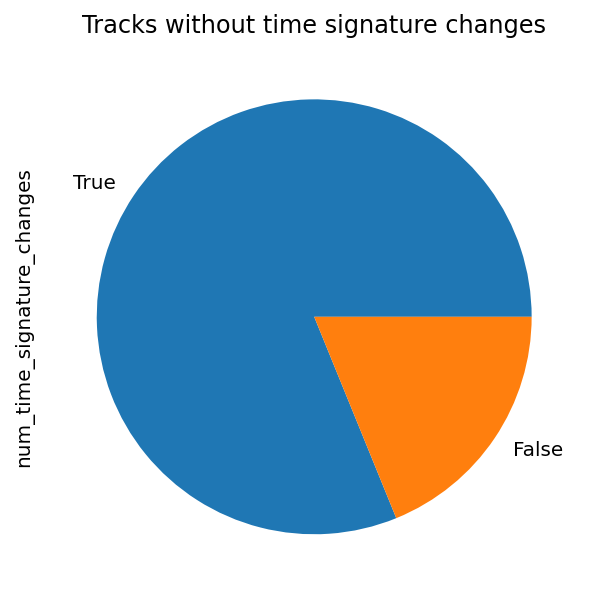

In [24]:
(midi_df.num_time_signature_changes <= 1).value_counts().plot.pie();
plt.title('Tracks without time signature changes');

We can also take a look at the most common instrument names in our dataset.

In [25]:
midi_df.explode('instrument_names').instrument_names.value_counts().head(20)

                  354674
Bass               29531
Drums              19437
untitled           18471
Piano              16342
Strings            10923
Soprano            10478
Guitar             10126
Alto                9368
Tenor               8987
DRUMS               8014
Melody              6693
WinJammer Demo      6488
Voice               6270
Piano (hi)          4905
Piano (lo)          4900
Italian             4679
STRINGS             4003
bass                3785
MELODY              3775
Name: instrument_names, dtype: int64

And also take a look at the most common names of our original filenames.

In [26]:
midi_df.sort_values('num_names', ascending=False).head(10)

beat_start drums    end_time  \
105645         NaN  None         NaN   
140258         NaN  None         NaN   
3815      1.500000  True  149.996094   
137550    0.000000  True  368.695560   
40890     4.210520  True  263.157500   
13452     0.638298  True  239.973452   
35183     3.157890  True  147.484755   
90521     2.536842  True  193.159651   
18774     3.485049  True  121.956351   
62115     4.950000  True  164.699980   

                                                file_path  \
105645  ../datasets/lmd/lmd_full/d/d41d8cd98f00b204e98...   
140258  ../datasets/lmd/lmd_full/e/ea1346344936b7397f2...   
3815    ../datasets/lmd/lmd_full/9/98b7b924eb5c5fcfbd6...   
137550  ../datasets/lmd/lmd_full/e/e651708cb4e24e60a5b...   
40890   ../datasets/lmd/lmd_full/6/697d99bf3aee8effc28...   
13452   ../datasets/lmd/lmd_full/0/05607e50402c0bb1a8a...   
35183   ../datasets/lmd/lmd_full/6/675fe9788c44ef27d3d...   
90521   ../datasets/lmd/lmd_full/c/c507304afe6cddba192...   
18774   ../datasets/lmd/lmd_full/0/07f7181fb5ff6e87cd6...   
62115   ../datasets/lmd/lmd_full/8/88666265d8e30cf7ef1...   

                                         instrument_names  midi_error  \
105645                                               None        True   
140258                                               None        True   
3815    [Organ 3 Lead, Organ 3 Harmony, Harmonica, Nyl...       False   
137550  [Vocals, Guitar 1, Guitar 2, Guitar 3, Guitar ...       False   
40890                      [, , , , , , , , , , , , , , ]       False   
13452   [Percussion, Percussion, Bass, High synth, Flu...       False   
35183   [Fretless Bass, Lead Flute, Aah Double, Ooh 1,...       False   
90521   [Flute, Synth Bass, Synth Bass 2, Orch Hit, Ef...       False   
18774                                    [, , , , , , , ]       False   
62115   [Fretless E.Bass, Nylon Gtr, Rock Org Lead, Oo...       False   

        num_time_signature_changes  resolution       tempo  \
105645                         NaN         NaN         NaN   
140258                         NaN         NaN         NaN   
3815                           1.0        96.0  232.563380   
137550                        13.0       120.0  238.815999   
40890                          2.0       192.0  228.715629   
13452                          1.0       120.0  189.167664   
35183                          7.0        96.0  181.250133   
90521                          1.0       120.0  206.513514   
18774                          1.0       192.0  201.848937   
62115                          1.0        96.0  208.075417   

                                           original_names  num_names  
105645  [Mccartney Paul/Bluebird Paul and Linda Mccart...        505  
140258  [Sure.Polyphone.Midi/Hangon.MID, Sure.Polyphon...        116  
3815    [Sure.Polyphone.Midi/Love Me Do.mid, l/loveme0...         73  
137550  [U/Unforgiven 2.mid, t/theunforgiven2.mid, Met...         68  
40890   [VARIOUS/U 2 - Don`t You Forget Me.mid, D/Don'...         67  
13452   [Sure.Polyphone.Midi/Dr - Dre.MID, Sure.Polyph...         62  
35183   [A/Atasteofhoney.mid, a/atasteof.mid, Beatles,...         59  
90521   [Sure.Polyphone.Midi/15.mid, m/mission-g-g.mid...         59  
18774   [BeachBoys/Pleasepleaseme.mid, p/please3.mid, ...         58  
62115   [BeachBoys/Doyouwanttoknowasecret.mid, s/secre...         57

In [27]:
midi_df.explode('original_names').original_names.str.replace('[^a-zA-Z]', ' ').str.lower().str.split(' ').explode().value_counts().head(50)

              1091324
mid            570786
midi            56765
various         42479
artists         36610
a               34883
the             34148
l               29181
s               28479
polyphone       24771
sure            23089
i               22765
m               20958
e               20792
t               19164
midis           19014
c               18162
b               17950
d               17712
n               17012
h               15452
o               15425
g               13303
you             13228
p               12267
k               12032
of              11890
poly            11836
in              11073
f               10433
beatles          9696
love             9246
r                8911
me               8901
j                8816
diversen         8643
my               8172
to               7585
divers           7025
w                6894
analisadas       6320
no               6073
de               5601
on               5373
and              5349
midirip   

An interesting aspect of this analyis reveals that the most common words in a text corpora do not often contain much information what the text is about because the grammar structure of the text introduces noise to the dataset.

There are basic algorithms such as [tf-idf](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) which allows us to filter out the noise by asserting that a word which is common in many documents has little to no meaning (e.g. *the* or in our case *midi*) and therefore give it a low score.
Although if a significant subset of our file names contain a word that is not so common in the other file names (e.g. *beatles*) this *token* will receive a high rating.

For now we dont want to inspect this further but its always good to know such kind of algorithms as it helps to filter out the relevant data.

Its also good to make some sanity checks on our data.
One assumption would be that every file in which we did not detect a drum track also does not contain an instrument with the name *drums*.

In [28]:
explodeded_df = midi_df.explode('instrument_names')
explodeded_df[
    (explodeded_df['instrument_names'].str.lower().isin(['drums', 'drum']))&
    (explodeded_df['drums'] == False)
].groupby('file_path').first().reset_index()

file_path  beat_start  drums  \
0    ../datasets/lmd/lmd_full/0/0093ffc81428aabfa14...    2.210523  False   
1    ../datasets/lmd/lmd_full/0/032e298d9560fdbe954...    4.423678  False   
2    ../datasets/lmd/lmd_full/0/043e1c01e58a4bb4499...   18.071422  False   
3    ../datasets/lmd/lmd_full/0/06f86377b1dbad0ebf0...    1.000000  False   
4    ../datasets/lmd/lmd_full/0/078e2cc7c46eb5de726...    1.224488  False   
..                                                 ...         ...    ...   
148  ../datasets/lmd/lmd_full/f/f2a97c0f7fa26244a77...   11.999988  False   
149  ../datasets/lmd/lmd_full/f/f6702b2445a6ce9aa8e...    1.066667  False   
150  ../datasets/lmd/lmd_full/f/f8a56c3ebc00bfef70d...    6.000000  False   
151  ../datasets/lmd/lmd_full/f/fa06799e6825c6a4095...    8.053700  False   
152  ../datasets/lmd/lmd_full/f/fd37e5d1258ba97fc0e...    0.610000  False   

       end_time instrument_names  midi_error  num_time_signature_changes  \
0    137.151110            Drums       False                         1.0   
1    114.947196            Drums       False                         1.0   
2    196.778591            Drums       False                         1.0   
3     59.483692            DRUMS       False                         1.0   
4    281.211322            Drums       False                         1.0   
..          ...              ...         ...                         ...   
148  213.553358            drums       False                         1.0   
149   21.241667            Drums       False                         1.0   
150  263.847656            Drums       False                         1.0   
151  383.315852            drums       False                        16.0   
152  191.795000            Drums       False                         1.0   

     resolution       tempo  \
0         192.0  190.000285   
1         120.0  120.000180   
2         120.0  139.999977   
3         192.0  226.482465   
4         192.0  204.052854   
..          ...         ...   
148       192.0  218.459582   
149       480.0  211.143695   
150       192.0  157.793103   
151       240.0  284.928064   
152       120.0  235.685752   

                                        original_names  num_names  
0    [M/Martha My Dear 3.mid, Beatles +GeorgeJohnPa...         15  
1                     [s/smetmoth.mid, S/smetmoth.mid]          2  
2                             [Songs+300/Tunnel_o.mid]          1  
3                   [s/seaquest2.mid, S/seaquest2.mid]          2  
4    [Pop/SLEGDEHM.MID, PeterGabriel/Sledgehammer6....          4  
..                                                 ...        ...  
148   [u/unchainedmelody3.mid, U/UnchainedMelody3.mid]          2  
149               [e/ElectroJam.Mid, E/ElectroJam.Mid]          2  
150               [t/tearinhand.mid, T/tearinhand.mid]          2  
151                       [l/louder.mid, L/louder.mid]          2  
152  [Christian/Easyway.mid, Various Artists/easywa...         11  

[153 rows x 11 columns]

Listening to those examples reveal that some of them use another instrument than drums for their drums - either by artistic choice or by mistake.
As this only applies to 32 files we can live with this error and ignore the files were we did not detect the drum track.

## Filter and extract the data

After inspecting all availabe files we should filter out some *noisy* files that are either not interesting to us (they lack a drum track) or the parsing of the MIDI files did not work as expected.
With the analysis above we can verify borders of data we want to allow.


In [29]:
filtered_midi_df = midi_df[
    (midi_df.drums == True)
    & (midi_df.midi_error == False)
    & (midi_df.end_time.between(30, 800))
    & (midi_df.num_time_signature_changes<=1)
    & (midi_df.beat_start <= 20)
    & (midi_df.tempo <= 500)
]
filtered_midi_df

beat_start drums    end_time  \
5         3.652173  True  296.347752   
9         4.547617  True  225.896259   
10        5.419184  True  216.460946   
11        4.363632  True  310.029993   
12        3.545451  True  222.766823   
...            ...   ...         ...   
178555    5.999994  True  250.221166   
178556    0.000000  True  299.296908   
178557    2.962596  True  139.390142   
178559    3.802815  True  172.389879   
178560    0.923077  True  293.317332   

                                                file_path  \
5       ../datasets/lmd/lmd_full/9/9d30679480d0e55a07b...   
9       ../datasets/lmd/lmd_full/9/974f5b2466a5d5670df...   
10      ../datasets/lmd/lmd_full/9/952df587b9fff5adbeb...   
11      ../datasets/lmd/lmd_full/9/93e2cb3a0c36af361bb...   
12      ../datasets/lmd/lmd_full/9/97c1f795ffb676dfaa5...   
...                                                   ...   
178555  ../datasets/lmd/lmd_full/5/5bd52f314b616bf50c4...   
178556  ../datasets/lmd/lmd_full/5/5eea68ee369af3ee5cc...   
178557  ../datasets/lmd/lmd_full/5/5309fb3f62bf73780e6...   
178559  ../datasets/lmd/lmd_full/5/5538b0174111bcef760...   
178560  ../datasets/lmd/lmd_full/5/51e756897765aed30af...   

                                         instrument_names  midi_error  \
5       [Piano, Organ, Big Brass, Horns, Horns2, Horns...       False   
9                                    [, , , , , , , , , ]       False   
10      [Track 2, Track 3, Track 4, Track 5, Track 6, ...       False   
11      [Chorus Guitar, Overdrive Guita, Overdrive Gui...       False   
12      [BASS, E.PIANO, GUITAR, STRINGS, PIANO, New Tr...       False   
...                                                   ...         ...   
178555  [Track 1, Track 2, Track 3, Track 4, Track 6, ...       False   
178556  [You've Made Me So Very Happy, You've Made Me ...       False   
178557                               [, , , , , , , , , ]       False   
178559  [Std Drums, Jazz Gtr, Muted Gtr (Lead Dbl), Mu...       False   
178560                                       [, , , , , ]       False   

        num_time_signature_changes  resolution       tempo  \
5                              1.0       120.0  224.502048   
9                              1.0       120.0  184.213982   
10                             1.0       480.0  265.636110   
11                             1.0       480.0  165.000165   
12                             1.0       192.0  212.877687   
...                            ...         ...         ...   
178555                         1.0       480.0  141.332152   
178556                         1.0       240.0  184.252715   
178557                         1.0       120.0  183.172080   
178559                         1.0        96.0  274.353398   
178560                         1.0        96.0  229.821409   

                                           original_names  num_names  
5                                         [S/Smooth .mid]          1  
9       [Sure.Polyphone.Midi/A Winter's Tale.mid, w/wi...         10  
10      [E/Enola Gay 63.mid, divers midi 3/OMD_-_Enola...          2  
11                       [z/zombie05.mid, Z/zombie05.mid]          2  
12      [J/J. Rivers Poor Side of Town.mid, divers mid...          2  
...                                                   ...        ...  
178555                    [T/taylor_swift-tim_mcgraw.mid]          1  
178556  [Y/Youvemad L.mid, Y/YOUVEMAD L.mid, Y/YOUVEMA...          4  
178557  [R/Roberto Carlos - Propuesta L.mid, Midis Jov...          3  
178559  [B/Boys 2.mid, b/boys_2.mid, Beatles +GeorgeJo...         16  
178560                      [G/Gerry Boulet Deadline.mid]          1  

[97615 rows x 11 columns]

We now filtered half of our available examples by just looking at the metadata of the MIDI files.
The next step is to extract the drum track of each MIDI filtered MIDI file and save the extracted MIDI file so we can analyse the patterns in of those drum patterns in the next step.

As this part is also computational quite heavy we will again use caching here.

In [30]:
def extract_drums(row, extract_path:str = '../datasets/lmd/lmd_drums/'):
    os.makedirs(extract_path, exist_ok=True)
    file_path = row['file_path']
    
    extracted_path = os.path.join(
        extract_path,
        f'{os.path.splitext(file_path.split(os.sep)[-1])[0]}.mid'
    )
    
    if os.path.isfile(extract_path):
        row['extracted_file_path'] = extracted_path
    else:
        try:
            sound = pm.PrettyMIDI(file_path)
            sound.instruments = [i for i in sound.instruments if i.is_drum]
            sound.write(extracted_path)
            row['extracted_file_path'] = extracted_path
        except Exception as e:
            print(f'Failed to extract {file_path}: {e}')
            row['fail_extract'] = True
    return row

def load_extracted_drums_df(
    filtered_midi_df: pd.DataFrame,
    save_path:str ='extracted_drums_df.parquet',
    force_reload: bool = False
) -> pd.DataFrame:
    if os.path.isfile(save_path) and not force_reload:
        print(f'Load dataframe from {save_path}')
        df = pd.read_parquet(save_path)
        if not(len(df)==len(filtered_midi_df)):
            print(f'Loaded dataframe does not match filtered - consider rebuild of cache')
        return df
    
    df = filtered_midi_df.swifter.apply(extract_drums, axis=1)
    df.to_parquet(save_path)
    print(f'Saved dataframe in {save_path}')
    
    return df

In [31]:
extract_drums_df = load_extracted_drums_df(filtered_midi_df)
extract_drums_df

Load dataframe from extracted_drums_df.parquet


beat_start  drums    end_time  \
5         3.652173   True  296.347752   
9         4.547617   True  225.896259   
10        5.419184   True  216.460946   
11        4.363632   True  310.029993   
12        3.545451   True  222.766823   
...            ...    ...         ...   
178555    5.999994   True  250.221166   
178556    0.000000   True  299.296908   
178557    2.962596   True  139.390142   
178559    3.802815   True  172.389879   
178560    0.923077   True  293.317332   

                                                file_path  \
5       ../datasets/lmd/lmd_full/9/9d30679480d0e55a07b...   
9       ../datasets/lmd/lmd_full/9/974f5b2466a5d5670df...   
10      ../datasets/lmd/lmd_full/9/952df587b9fff5adbeb...   
11      ../datasets/lmd/lmd_full/9/93e2cb3a0c36af361bb...   
12      ../datasets/lmd/lmd_full/9/97c1f795ffb676dfaa5...   
...                                                   ...   
178555  ../datasets/lmd/lmd_full/5/5bd52f314b616bf50c4...   
178556  ../datasets/lmd/lmd_full/5/5eea68ee369af3ee5cc...   
178557  ../datasets/lmd/lmd_full/5/5309fb3f62bf73780e6...   
178559  ../datasets/lmd/lmd_full/5/5538b0174111bcef760...   
178560  ../datasets/lmd/lmd_full/5/51e756897765aed30af...   

                                         instrument_names  midi_error  \
5       [Piano, Organ, Big Brass, Horns, Horns2, Horns...       False   
9                                    [, , , , , , , , , ]       False   
10      [Track 2, Track 3, Track 4, Track 5, Track 6, ...       False   
11      [Chorus Guitar, Overdrive Guita, Overdrive Gui...       False   
12      [BASS, E.PIANO, GUITAR, STRINGS, PIANO, New Tr...       False   
...                                                   ...         ...   
178555  [Track 1, Track 2, Track 3, Track 4, Track 6, ...       False   
178556  [You've Made Me So Very Happy, You've Made Me ...       False   
178557                               [, , , , , , , , , ]       False   
178559  [Std Drums, Jazz Gtr, Muted Gtr (Lead Dbl), Mu...       False   
178560                                       [, , , , , ]       False   

        num_time_signature_changes  resolution       tempo  \
5                              1.0       120.0  224.502048   
9                              1.0       120.0  184.213982   
10                             1.0       480.0  265.636110   
11                             1.0       480.0  165.000165   
12                             1.0       192.0  212.877687   
...                            ...         ...         ...   
178555                         1.0       480.0  141.332152   
178556                         1.0       240.0  184.252715   
178557                         1.0       120.0  183.172080   
178559                         1.0        96.0  274.353398   
178560                         1.0        96.0  229.821409   

                                      extracted_file_path  
5       ../datasets/lmd/lmd_drums/9d30679480d0e55a07be...  
9       ../datasets/lmd/lmd_drums/974f5b2466a5d5670dfd...  
10      ../datasets/lmd/lmd_drums/952df587b9fff5adbeb5...  
11      ../datasets/lmd/lmd_drums/93e2cb3a0c36af361bb4...  
12      ../datasets/lmd/lmd_drums/97c1f795ffb676dfaa5a...  
...                                                   ...  
178555  ../datasets/lmd/lmd_drums/5bd52f314b616bf50c40...  
178556  ../datasets/lmd/lmd_drums/5eea68ee369af3ee5cc5...  
178557  ../datasets/lmd/lmd_drums/5309fb3f62bf73780e61...  
178559  ../datasets/lmd/lmd_drums/5538b0174111bcef760a...  
178560  ../datasets/lmd/lmd_drums/51e756897765aed30af2...  

[97615 rows x 10 columns]

## Conclusion

We now filtered out all unwanted parts of our dataset and isolated the drum track to a new MIDI file.

In the next step we will start to analyse the drum patterns that we extracted.